## Utils

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    npimg = denormalize(img)
    plt.imsave("matplotlib.png", npimg, cmap="gray")
    # plt.imshow(npimg, cmap="gray") # Not working on my WSL2 on Windows 11


def denormalize(img):
    channel_means = (0.4914, 0.4822, 0.4465)
    channel_stdevs = (0.2470, 0.2435, 0.2616)
    img = img.numpy().astype(dtype=np.float32)

    for i in range(img.shape[0]):
        img[i] = (img[i] * channel_stdevs[i]) + channel_means[i]

    return np.transpose(img, (1, 2, 0))


## Transformer

In [2]:
from albumentations import (
    Compose,
    Normalize,
    HorizontalFlip,
    CoarseDropout,
    ShiftScaleRotate,
)
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np


class Transforms:
    def __init__(self, means, stds, train=True):
        if train:
            self.transformations = Compose(
                [
                    HorizontalFlip(),
                    ShiftScaleRotate(),
                    CoarseDropout(
                        min_holes=1,
                        max_holes=1,
                        min_height=16,
                        max_height=16,
                        min_width=16,
                        max_width=16,
                        fill_value=[x * 255 for x in means],  # type: ignore
                        mask_fill_value=None,
                    ),
                    Normalize(mean=means, std=stds),
                    ToTensorV2(),
                ]
            )
        else:
            self.transformations = Compose(
                [
                    Normalize(mean=means, std=stds),
                    ToTensorV2(),
                ]
            )

    def __call__(self, img):
        return self.transformations(image=np.array(img))["image"]


## Data Loader

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets

import numpy as np


class Cifar10DataLoader:
    def __init__(self, batch_size=128, is_cuda_available=False) -> None:
        self.batch_size = batch_size
        self.dataloader_args = {"shuffle": True, "batch_size": self.batch_size}
        self.means = [0.4914, 0.4822, 0.4465]
        self.stds = [0.2470, 0.2435, 0.2616]

        if is_cuda_available:
            self.dataloader_args["num_workers"] = 2
            self.dataloader_args["pin_memory"] = True

        self.classes = (
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        )

    def get_dataset(self, train=True):
        return datasets.CIFAR10(
            "./data",
            train=train,
            transform=Transforms(self.means, self.stds, train),
            download=True,
        )

    def get_loader(self, train=True):
        return DataLoader(self.get_dataset(train), **self.dataloader_args)

    def get_classes(self):
        return self.classes


## Training and Testing

In [4]:
import torch
from tqdm import tqdm


class Trainer:
    def __init__(self) -> None:
        self.train_losses = []
        self.train_accuracies = []
        self.epoch_train_accuracies = []

    def train(self, model, dataloader, optimizer, criterion, device, epoch):
        model.train()
        correct = 0
        processed = 0

        pbar = tqdm(dataloader)

        for batch_id, (inputs, targets) in enumerate(pbar):
            # transfer to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Initialize gradients to 0
            optimizer.zero_grad()

            # Prediction
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)
            self.train_losses.append(loss.item())

            # Backpropagation
            loss.backward()
            optimizer.step()

            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()
            processed += len(inputs)

            pbar.set_description(
                desc=f"EPOCH = {epoch} | LR = {optimizer.param_groups[0]['lr']} | Loss = {loss.item():3.2f} | Batch = {batch_id} | Accuracy = {100*correct/processed:0.2f}"
            )
            self.train_accuracies.append(100 * correct / processed)

        # After all the batches are done, append accuracy for epoch
        self.epoch_train_accuracies.append(100 * correct / processed)
        return 100 * correct / processed


class Tester:
    def __init__(self) -> None:
        self.test_losses = []
        self.test_accuracies = []

    def test(self, model, dataloader, criterion, device):
        model.eval()

        test_loss = 0
        correct = 0

        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs)
                loss = criterion(output, targets)

                test_loss += loss.item()

                pred = output.argmax(
                    dim=1, keepdim=True
                )  # get the index of the max log-probability
                correct += pred.eq(targets.view_as(pred)).sum().item()

        test_loss /= len(dataloader.dataset)
        self.test_losses.append(test_loss)

        print(
            "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
                test_loss,
                correct,
                len(dataloader.dataset),
                100.0 * correct / len(dataloader.dataset),
            )
        )

        self.test_accuracies.append(100.0 * correct / len(dataloader.dataset))


## Model

In [5]:
import torch.nn as nn


class DepthwiseConv(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        padding: int = 0,
        dilation: int = 1,
    ) -> None:
        super(DepthwiseConv, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=padding,
                groups=in_channels,
                dilation=dilation,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=1,
                bias=False,
            ),
        )

    def forward(self, x):
        x = self.conv_layer(x)
        return x


class ConvLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        padding: int = 0,
        use_depthwise: bool = False,
        use_skip: bool = False,
        dilation: int = 1,
        dropout: float = 0,
    ) -> None:
        super(ConvLayer, self).__init__()

        self.use_skip = use_skip

        if use_depthwise and in_channels == out_channels:
            self.conv_layer = DepthwiseConv(
                in_channels=in_channels,
                out_channels=out_channels,
                padding=padding,
                dilation=dilation,
            )
        else:
            self.conv_layer = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=padding,
                dilation=dilation,
                bias=False,
            )

        self.norm_layer = nn.BatchNorm2d(out_channels)

        self.skip_layer = None

        if use_skip and in_channels != out_channels:
            self.skip_layer = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                bias=False,
            )

        self.activation_layer = nn.ReLU()

        self.drop_layer = None
        if dropout > 0:
            self.drop_layer = nn.Dropout(dropout)

    def forward(self, x):
        y = x
        x = self.conv_layer(x)
        x = self.norm_layer(x)

        if self.use_skip:
            x += y if self.skip_layer is None else self.skip_layer(y)

        x = self.activation_layer(x)

        if self.drop_layer is not None:
            x = self.drop_layer(x)

        return x


class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        num_layers: int = 1,
        padding: int = 0,
        use_depthwise: bool = False,
        use_skip: bool = False,
        dilation: int = 1,
        dropout: float = 0,
    ):
        super(ConvBlock, self).__init__()

        self.conv_block = nn.Sequential(
            *[
                ConvLayer(
                    in_channels=(in_channels if i == 0 else out_channels),
                    out_channels=out_channels,
                    padding=padding,
                    use_depthwise=use_depthwise,
                    use_skip=use_skip,
                    dilation=dilation,
                    dropout=dropout,
                )
                for i in range(num_layers)
            ]
        )

    def forward(self, x):
        x = self.conv_block(x)
        return x


class TransBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        padding: int = 0,
        use_depthwise: bool = False,
        use_skip: bool = False,
        dilation: int = 1,
        dropout: float = 0,
    ):
        super(TransBlock, self).__init__()

        self.trans_block = ConvLayer(
            in_channels=in_channels,
            out_channels=out_channels,
            padding=padding,
            use_depthwise=use_depthwise,
            use_skip=use_skip,
            dilation=dilation,
            dropout=dropout,
        )

    def forward(self, x):
        x = self.trans_block(x)
        return x


class Net(nn.Module):
    def __init__(
        self,
        dropout: float = 0,
        use_skip: bool = False,
    ):
        super(Net, self).__init__()

        self.dropout = dropout

        self.conv_block1 = ConvBlock(
            in_channels=3,
            out_channels=25,
            padding=1,
            use_depthwise=True,
            use_skip=False,
            num_layers=2,
            dropout=self.dropout,
        )
        self.trans_block1 = TransBlock(
            in_channels=25,
            out_channels=32,
            padding=0,
            use_depthwise=False,
            use_skip=False,
            dilation=1,
            dropout=self.dropout,
        )
        self.conv_block2 = ConvBlock(
            in_channels=32,
            out_channels=32,
            padding=1,
            use_depthwise=True,
            use_skip=use_skip,
            num_layers=2,
            dropout=self.dropout,
        )
        self.trans_block2 = TransBlock(
            in_channels=32,
            out_channels=65,
            padding=0,
            use_depthwise=False,
            use_skip=False,
            dilation=2,
            dropout=self.dropout,
        )
        self.conv_block3 = ConvBlock(
            in_channels=65,
            out_channels=65,
            padding=1,
            use_depthwise=True,
            use_skip=use_skip,
            num_layers=2,
            dropout=self.dropout,
        )
        self.trans_block3 = TransBlock(
            in_channels=65,
            out_channels=95,
            padding=0,
            use_depthwise=False,
            use_skip=False,
            dilation=4,
            dropout=self.dropout,
        )
        self.conv_block4 = ConvBlock(
            in_channels=95,
            out_channels=95,
            padding=1,
            use_depthwise=True,
            use_skip=use_skip,
            num_layers=2,
            dropout=self.dropout,
        )
        self.trans_block4 = TransBlock(
            in_channels=95,
            out_channels=95,
            padding=0,
            use_depthwise=False,
            use_skip=False,
            dilation=8,
            dropout=0,
        )

        self.out_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(95, 10, 1, bias=True),
            nn.Flatten(),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.trans_block1(x)
        x = self.conv_block2(x)
        x = self.trans_block2(x)
        x = self.conv_block3(x)
        x = self.trans_block3(x)
        x = self.conv_block4(x)
        x = self.trans_block4(x)
        x = self.out_block(x)

        return x


# **Model Summary**


In [8]:
import torch
from torchinfo import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)
batch_size = 2
summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    depth=4,
    col_width=18,
    col_names=[
        "kernel_size",
        "input_size",
        "output_size",
        "num_params",
        "trainable",
    ],
    row_settings=["var_names"],
)

Layer (type (var_name))                            Kernel Shape       Input Shape        Output Shape       Param #            Trainable
Net (Net)                                          --                 [2, 3, 32, 32]     [2, 10]            --                 True
├─ConvBlock (conv_block1)                          --                 [2, 3, 32, 32]     [2, 25, 32, 32]    --                 True
│    └─Sequential (conv_block)                     --                 [2, 3, 32, 32]     [2, 25, 32, 32]    --                 True
│    │    └─ConvLayer (0)                          --                 [2, 3, 32, 32]     [2, 25, 32, 32]    --                 True
│    │    │    └─Conv2d (conv_layer)               [3, 3]             [2, 3, 32, 32]     [2, 25, 32, 32]    675                True
│    │    │    └─BatchNorm2d (norm_layer)          --                 [2, 25, 32, 32]    [2, 25, 32, 32]    50                 True
│    │    │    └─ReLU (activation_layer)           --                 [

# **Initializing Dataloaders for Training and Testing**


In [9]:
cifar10 = Cifar10DataLoader(is_cuda_available=use_cuda)
train_loader = cifar10.get_loader(True)
test_loader = cifar10.get_loader(False)

100%|██████████| 170498071/170498071 [00:04<00:00, 35160901.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# **Training the model**


In [10]:
import torch.optim as optim
import torch.nn as nn

trainer = Trainer()
tester = Tester()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.NLLLoss()

EPOCHS = 200

for epoch in range(EPOCHS):
    trainer.train(model, train_loader, optimizer, criterion, device, epoch)
    tester.test(model, test_loader, criterion, device)

  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
EPOCH = 0 | LR = 0.001 | Loss = 1.95 | Batch = 390 | Accuracy = 19.86: 100%|██████████| 391/391 [00:25<00:00, 15.30it/s]


Test set: Average loss: 0.0150, Accuracy: 3011/10000 (30.11%)



EPOCH = 1 | LR = 0.001 | Loss = 1.72 | Batch = 390 | Accuracy = 32.22: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0132, Accuracy: 3840/10000 (38.40%)



EPOCH = 2 | LR = 0.001 | Loss = 1.79 | Batch = 390 | Accuracy = 38.10: 100%|██████████| 391/391 [00:23<00:00, 16.94it/s]


Test set: Average loss: 0.0122, Accuracy: 4291/10000 (42.91%)



EPOCH = 3 | LR = 0.001 | Loss = 1.53 | Batch = 390 | Accuracy = 40.92: 100%|██████████| 391/391 [00:23<00:00, 16.43it/s]


Test set: Average loss: 0.0115, Accuracy: 4666/10000 (46.66%)



EPOCH = 4 | LR = 0.001 | Loss = 1.35 | Batch = 390 | Accuracy = 43.03: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 0.0111, Accuracy: 4855/10000 (48.55%)



EPOCH = 5 | LR = 0.001 | Loss = 1.38 | Batch = 390 | Accuracy = 44.31: 100%|██████████| 391/391 [00:23<00:00, 16.69it/s]


Test set: Average loss: 0.0108, Accuracy: 5062/10000 (50.62%)



EPOCH = 6 | LR = 0.001 | Loss = 1.57 | Batch = 390 | Accuracy = 46.21: 100%|██████████| 391/391 [00:23<00:00, 16.93it/s]


Test set: Average loss: 0.0106, Accuracy: 5125/10000 (51.25%)



EPOCH = 7 | LR = 0.001 | Loss = 1.41 | Batch = 390 | Accuracy = 47.66: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Test set: Average loss: 0.0100, Accuracy: 5387/10000 (53.87%)



EPOCH = 8 | LR = 0.001 | Loss = 1.26 | Batch = 390 | Accuracy = 48.86: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 0.0096, Accuracy: 5585/10000 (55.85%)



EPOCH = 9 | LR = 0.001 | Loss = 1.18 | Batch = 390 | Accuracy = 50.07: 100%|██████████| 391/391 [00:22<00:00, 17.06it/s]


Test set: Average loss: 0.0095, Accuracy: 5651/10000 (56.51%)



EPOCH = 10 | LR = 0.001 | Loss = 1.37 | Batch = 390 | Accuracy = 51.06: 100%|██████████| 391/391 [00:22<00:00, 17.04it/s]


Test set: Average loss: 0.0091, Accuracy: 5816/10000 (58.16%)



EPOCH = 11 | LR = 0.001 | Loss = 1.37 | Batch = 390 | Accuracy = 52.10: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s]


Test set: Average loss: 0.0089, Accuracy: 5936/10000 (59.36%)



EPOCH = 12 | LR = 0.001 | Loss = 1.22 | Batch = 390 | Accuracy = 53.46: 100%|██████████| 391/391 [00:22<00:00, 17.37it/s]


Test set: Average loss: 0.0087, Accuracy: 6028/10000 (60.28%)



EPOCH = 13 | LR = 0.001 | Loss = 1.20 | Batch = 390 | Accuracy = 54.39: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0086, Accuracy: 6053/10000 (60.53%)



EPOCH = 14 | LR = 0.001 | Loss = 1.18 | Batch = 390 | Accuracy = 54.97: 100%|██████████| 391/391 [00:23<00:00, 16.98it/s]


Test set: Average loss: 0.0084, Accuracy: 6170/10000 (61.70%)



EPOCH = 15 | LR = 0.001 | Loss = 1.23 | Batch = 390 | Accuracy = 55.43: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0081, Accuracy: 6286/10000 (62.86%)



EPOCH = 16 | LR = 0.001 | Loss = 1.38 | Batch = 390 | Accuracy = 55.98: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 0.0080, Accuracy: 6342/10000 (63.42%)



EPOCH = 17 | LR = 0.001 | Loss = 1.13 | Batch = 390 | Accuracy = 57.14: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s]


Test set: Average loss: 0.0078, Accuracy: 6443/10000 (64.43%)



EPOCH = 18 | LR = 0.001 | Loss = 1.02 | Batch = 390 | Accuracy = 57.50: 100%|██████████| 391/391 [00:22<00:00, 17.27it/s]


Test set: Average loss: 0.0078, Accuracy: 6517/10000 (65.17%)



EPOCH = 19 | LR = 0.001 | Loss = 1.32 | Batch = 390 | Accuracy = 58.21: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s]


Test set: Average loss: 0.0077, Accuracy: 6491/10000 (64.91%)



EPOCH = 20 | LR = 0.001 | Loss = 1.11 | Batch = 390 | Accuracy = 58.80: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0076, Accuracy: 6548/10000 (65.48%)



EPOCH = 21 | LR = 0.001 | Loss = 1.08 | Batch = 390 | Accuracy = 59.21: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0074, Accuracy: 6633/10000 (66.33%)



EPOCH = 22 | LR = 0.001 | Loss = 0.95 | Batch = 390 | Accuracy = 60.11: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0074, Accuracy: 6673/10000 (66.73%)



EPOCH = 23 | LR = 0.001 | Loss = 1.21 | Batch = 390 | Accuracy = 60.60: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 0.0071, Accuracy: 6801/10000 (68.01%)



EPOCH = 24 | LR = 0.001 | Loss = 1.07 | Batch = 390 | Accuracy = 61.03: 100%|██████████| 391/391 [00:23<00:00, 16.92it/s]


Test set: Average loss: 0.0070, Accuracy: 6884/10000 (68.84%)



EPOCH = 25 | LR = 0.001 | Loss = 1.11 | Batch = 390 | Accuracy = 61.48: 100%|██████████| 391/391 [00:23<00:00, 16.90it/s]


Test set: Average loss: 0.0069, Accuracy: 6917/10000 (69.17%)



EPOCH = 26 | LR = 0.001 | Loss = 1.41 | Batch = 390 | Accuracy = 62.10: 100%|██████████| 391/391 [00:23<00:00, 16.83it/s]


Test set: Average loss: 0.0068, Accuracy: 6965/10000 (69.65%)



EPOCH = 27 | LR = 0.001 | Loss = 0.90 | Batch = 390 | Accuracy = 62.46: 100%|██████████| 391/391 [00:23<00:00, 16.80it/s]


Test set: Average loss: 0.0068, Accuracy: 6949/10000 (69.49%)



EPOCH = 28 | LR = 0.001 | Loss = 1.12 | Batch = 390 | Accuracy = 62.73: 100%|██████████| 391/391 [00:23<00:00, 16.76it/s]


Test set: Average loss: 0.0068, Accuracy: 6926/10000 (69.26%)



EPOCH = 29 | LR = 0.001 | Loss = 0.76 | Batch = 390 | Accuracy = 62.85: 100%|██████████| 391/391 [00:23<00:00, 16.83it/s]


Test set: Average loss: 0.0066, Accuracy: 7080/10000 (70.80%)



EPOCH = 30 | LR = 0.001 | Loss = 0.95 | Batch = 390 | Accuracy = 63.33: 100%|██████████| 391/391 [00:23<00:00, 17.00it/s]


Test set: Average loss: 0.0065, Accuracy: 7066/10000 (70.66%)



EPOCH = 31 | LR = 0.001 | Loss = 0.98 | Batch = 390 | Accuracy = 63.80: 100%|██████████| 391/391 [00:23<00:00, 16.99it/s]


Test set: Average loss: 0.0065, Accuracy: 7104/10000 (71.04%)



EPOCH = 32 | LR = 0.001 | Loss = 0.80 | Batch = 390 | Accuracy = 64.34: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Test set: Average loss: 0.0063, Accuracy: 7132/10000 (71.32%)



EPOCH = 33 | LR = 0.001 | Loss = 1.00 | Batch = 390 | Accuracy = 64.39: 100%|██████████| 391/391 [00:23<00:00, 16.92it/s]


Test set: Average loss: 0.0063, Accuracy: 7193/10000 (71.93%)



EPOCH = 34 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 64.50: 100%|██████████| 391/391 [00:23<00:00, 16.98it/s]


Test set: Average loss: 0.0063, Accuracy: 7211/10000 (72.11%)



EPOCH = 35 | LR = 0.001 | Loss = 0.95 | Batch = 390 | Accuracy = 65.38: 100%|██████████| 391/391 [00:22<00:00, 17.01it/s]


Test set: Average loss: 0.0062, Accuracy: 7229/10000 (72.29%)



EPOCH = 36 | LR = 0.001 | Loss = 1.23 | Batch = 390 | Accuracy = 65.47: 100%|██████████| 391/391 [00:22<00:00, 17.00it/s]


Test set: Average loss: 0.0061, Accuracy: 7247/10000 (72.47%)



EPOCH = 37 | LR = 0.001 | Loss = 0.83 | Batch = 390 | Accuracy = 65.49: 100%|██████████| 391/391 [00:22<00:00, 17.14it/s]


Test set: Average loss: 0.0061, Accuracy: 7297/10000 (72.97%)



EPOCH = 38 | LR = 0.001 | Loss = 1.07 | Batch = 390 | Accuracy = 66.00: 100%|██████████| 391/391 [00:22<00:00, 17.01it/s]


Test set: Average loss: 0.0060, Accuracy: 7300/10000 (73.00%)



EPOCH = 39 | LR = 0.001 | Loss = 0.88 | Batch = 390 | Accuracy = 66.52: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]


Test set: Average loss: 0.0060, Accuracy: 7300/10000 (73.00%)



EPOCH = 40 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 66.63: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0059, Accuracy: 7358/10000 (73.58%)



EPOCH = 41 | LR = 0.001 | Loss = 1.04 | Batch = 390 | Accuracy = 66.68: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s]


Test set: Average loss: 0.0059, Accuracy: 7387/10000 (73.87%)



EPOCH = 42 | LR = 0.001 | Loss = 1.04 | Batch = 390 | Accuracy = 67.16: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s]


Test set: Average loss: 0.0058, Accuracy: 7404/10000 (74.04%)



EPOCH = 43 | LR = 0.001 | Loss = 0.86 | Batch = 390 | Accuracy = 67.48: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s]


Test set: Average loss: 0.0058, Accuracy: 7434/10000 (74.34%)



EPOCH = 44 | LR = 0.001 | Loss = 0.95 | Batch = 390 | Accuracy = 67.23: 100%|██████████| 391/391 [00:22<00:00, 17.31it/s]


Test set: Average loss: 0.0058, Accuracy: 7428/10000 (74.28%)



EPOCH = 45 | LR = 0.001 | Loss = 0.83 | Batch = 390 | Accuracy = 67.39: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Test set: Average loss: 0.0056, Accuracy: 7490/10000 (74.90%)



EPOCH = 46 | LR = 0.001 | Loss = 0.86 | Batch = 390 | Accuracy = 68.01: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s]


Test set: Average loss: 0.0056, Accuracy: 7531/10000 (75.31%)



EPOCH = 47 | LR = 0.001 | Loss = 0.73 | Batch = 390 | Accuracy = 68.27: 100%|██████████| 391/391 [00:22<00:00, 17.28it/s]


Test set: Average loss: 0.0057, Accuracy: 7488/10000 (74.88%)



EPOCH = 48 | LR = 0.001 | Loss = 1.00 | Batch = 390 | Accuracy = 68.40: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 0.0056, Accuracy: 7487/10000 (74.87%)



EPOCH = 49 | LR = 0.001 | Loss = 0.92 | Batch = 390 | Accuracy = 68.84: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s]


Test set: Average loss: 0.0056, Accuracy: 7501/10000 (75.01%)



EPOCH = 50 | LR = 0.001 | Loss = 0.84 | Batch = 390 | Accuracy = 68.66: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0054, Accuracy: 7591/10000 (75.91%)



EPOCH = 51 | LR = 0.001 | Loss = 0.94 | Batch = 390 | Accuracy = 69.12: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s]


Test set: Average loss: 0.0054, Accuracy: 7591/10000 (75.91%)



EPOCH = 52 | LR = 0.001 | Loss = 0.78 | Batch = 390 | Accuracy = 69.20: 100%|██████████| 391/391 [00:22<00:00, 17.28it/s]


Test set: Average loss: 0.0054, Accuracy: 7623/10000 (76.23%)



EPOCH = 53 | LR = 0.001 | Loss = 0.95 | Batch = 390 | Accuracy = 69.26: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]


Test set: Average loss: 0.0055, Accuracy: 7570/10000 (75.70%)



EPOCH = 54 | LR = 0.001 | Loss = 0.64 | Batch = 390 | Accuracy = 69.54: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s]


Test set: Average loss: 0.0053, Accuracy: 7640/10000 (76.40%)



EPOCH = 55 | LR = 0.001 | Loss = 0.85 | Batch = 390 | Accuracy = 69.87: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s]


Test set: Average loss: 0.0053, Accuracy: 7645/10000 (76.45%)



EPOCH = 56 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 69.87: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]


Test set: Average loss: 0.0053, Accuracy: 7666/10000 (76.66%)



EPOCH = 57 | LR = 0.001 | Loss = 0.63 | Batch = 390 | Accuracy = 69.76: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0053, Accuracy: 7648/10000 (76.48%)



EPOCH = 58 | LR = 0.001 | Loss = 0.69 | Batch = 390 | Accuracy = 70.17: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s]


Test set: Average loss: 0.0053, Accuracy: 7731/10000 (77.31%)



EPOCH = 59 | LR = 0.001 | Loss = 0.92 | Batch = 390 | Accuracy = 70.28: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s]


Test set: Average loss: 0.0053, Accuracy: 7689/10000 (76.89%)



EPOCH = 60 | LR = 0.001 | Loss = 0.88 | Batch = 390 | Accuracy = 70.67: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s]


Test set: Average loss: 0.0052, Accuracy: 7740/10000 (77.40%)



EPOCH = 61 | LR = 0.001 | Loss = 0.83 | Batch = 390 | Accuracy = 70.66: 100%|██████████| 391/391 [00:22<00:00, 17.31it/s]


Test set: Average loss: 0.0051, Accuracy: 7747/10000 (77.47%)



EPOCH = 62 | LR = 0.001 | Loss = 0.89 | Batch = 390 | Accuracy = 71.07: 100%|██████████| 391/391 [00:22<00:00, 17.13it/s]


Test set: Average loss: 0.0053, Accuracy: 7730/10000 (77.30%)



EPOCH = 63 | LR = 0.001 | Loss = 0.79 | Batch = 390 | Accuracy = 71.05: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Test set: Average loss: 0.0051, Accuracy: 7762/10000 (77.62%)



EPOCH = 64 | LR = 0.001 | Loss = 0.88 | Batch = 390 | Accuracy = 71.18: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


Test set: Average loss: 0.0051, Accuracy: 7800/10000 (78.00%)



EPOCH = 65 | LR = 0.001 | Loss = 0.77 | Batch = 390 | Accuracy = 71.45: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0052, Accuracy: 7724/10000 (77.24%)



EPOCH = 66 | LR = 0.001 | Loss = 0.61 | Batch = 390 | Accuracy = 71.55: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


Test set: Average loss: 0.0050, Accuracy: 7811/10000 (78.11%)



EPOCH = 67 | LR = 0.001 | Loss = 0.78 | Batch = 390 | Accuracy = 71.59: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0052, Accuracy: 7737/10000 (77.37%)



EPOCH = 68 | LR = 0.001 | Loss = 0.85 | Batch = 390 | Accuracy = 71.56: 100%|██████████| 391/391 [00:22<00:00, 17.28it/s]


Test set: Average loss: 0.0051, Accuracy: 7790/10000 (77.90%)



EPOCH = 69 | LR = 0.001 | Loss = 1.00 | Batch = 390 | Accuracy = 71.93: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s]


Test set: Average loss: 0.0049, Accuracy: 7807/10000 (78.07%)



EPOCH = 70 | LR = 0.001 | Loss = 0.73 | Batch = 390 | Accuracy = 71.94: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s]


Test set: Average loss: 0.0050, Accuracy: 7848/10000 (78.48%)



EPOCH = 71 | LR = 0.001 | Loss = 0.84 | Batch = 390 | Accuracy = 72.36: 100%|██████████| 391/391 [00:22<00:00, 17.06it/s]


Test set: Average loss: 0.0049, Accuracy: 7872/10000 (78.72%)



EPOCH = 72 | LR = 0.001 | Loss = 1.09 | Batch = 390 | Accuracy = 72.20: 100%|██████████| 391/391 [00:22<00:00, 17.03it/s]


Test set: Average loss: 0.0049, Accuracy: 7891/10000 (78.91%)



EPOCH = 73 | LR = 0.001 | Loss = 0.72 | Batch = 390 | Accuracy = 72.25: 100%|██████████| 391/391 [00:23<00:00, 16.95it/s]


Test set: Average loss: 0.0049, Accuracy: 7846/10000 (78.46%)



EPOCH = 74 | LR = 0.001 | Loss = 0.62 | Batch = 390 | Accuracy = 72.34: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]


Test set: Average loss: 0.0049, Accuracy: 7853/10000 (78.53%)



EPOCH = 75 | LR = 0.001 | Loss = 0.89 | Batch = 390 | Accuracy = 72.31: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]


Test set: Average loss: 0.0048, Accuracy: 7895/10000 (78.95%)



EPOCH = 76 | LR = 0.001 | Loss = 1.09 | Batch = 390 | Accuracy = 72.75: 100%|██████████| 391/391 [00:23<00:00, 16.74it/s]


Test set: Average loss: 0.0048, Accuracy: 7896/10000 (78.96%)



EPOCH = 77 | LR = 0.001 | Loss = 0.87 | Batch = 390 | Accuracy = 72.74: 100%|██████████| 391/391 [00:23<00:00, 16.96it/s]


Test set: Average loss: 0.0047, Accuracy: 7929/10000 (79.29%)



EPOCH = 78 | LR = 0.001 | Loss = 0.78 | Batch = 390 | Accuracy = 73.04: 100%|██████████| 391/391 [00:23<00:00, 16.86it/s]


Test set: Average loss: 0.0047, Accuracy: 7924/10000 (79.24%)



EPOCH = 79 | LR = 0.001 | Loss = 0.74 | Batch = 390 | Accuracy = 73.15: 100%|██████████| 391/391 [00:23<00:00, 16.95it/s]


Test set: Average loss: 0.0048, Accuracy: 7897/10000 (78.97%)



EPOCH = 80 | LR = 0.001 | Loss = 0.86 | Batch = 390 | Accuracy = 73.26: 100%|██████████| 391/391 [00:22<00:00, 17.01it/s]


Test set: Average loss: 0.0050, Accuracy: 7826/10000 (78.26%)



EPOCH = 81 | LR = 0.001 | Loss = 0.65 | Batch = 390 | Accuracy = 73.30: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 0.0048, Accuracy: 7931/10000 (79.31%)



EPOCH = 82 | LR = 0.001 | Loss = 0.66 | Batch = 390 | Accuracy = 73.27: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]


Test set: Average loss: 0.0048, Accuracy: 7957/10000 (79.57%)



EPOCH = 83 | LR = 0.001 | Loss = 0.93 | Batch = 390 | Accuracy = 73.59: 100%|██████████| 391/391 [00:23<00:00, 16.61it/s]


Test set: Average loss: 0.0047, Accuracy: 7923/10000 (79.23%)



EPOCH = 84 | LR = 0.001 | Loss = 0.84 | Batch = 390 | Accuracy = 73.78: 100%|██████████| 391/391 [00:23<00:00, 16.75it/s]


Test set: Average loss: 0.0048, Accuracy: 7902/10000 (79.02%)



EPOCH = 85 | LR = 0.001 | Loss = 0.83 | Batch = 390 | Accuracy = 73.70: 100%|██████████| 391/391 [00:23<00:00, 16.81it/s]


Test set: Average loss: 0.0048, Accuracy: 7936/10000 (79.36%)



EPOCH = 86 | LR = 0.001 | Loss = 0.63 | Batch = 390 | Accuracy = 73.87: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]


Test set: Average loss: 0.0046, Accuracy: 8015/10000 (80.15%)



EPOCH = 87 | LR = 0.001 | Loss = 0.78 | Batch = 390 | Accuracy = 73.98: 100%|██████████| 391/391 [00:23<00:00, 16.91it/s]


Test set: Average loss: 0.0046, Accuracy: 7994/10000 (79.94%)



EPOCH = 88 | LR = 0.001 | Loss = 0.93 | Batch = 390 | Accuracy = 73.77: 100%|██████████| 391/391 [00:23<00:00, 16.87it/s]


Test set: Average loss: 0.0046, Accuracy: 7984/10000 (79.84%)



EPOCH = 89 | LR = 0.001 | Loss = 0.58 | Batch = 390 | Accuracy = 74.02: 100%|██████████| 391/391 [00:23<00:00, 16.87it/s]


Test set: Average loss: 0.0048, Accuracy: 7929/10000 (79.29%)



EPOCH = 90 | LR = 0.001 | Loss = 1.09 | Batch = 390 | Accuracy = 74.24: 100%|██████████| 391/391 [00:23<00:00, 16.96it/s]


Test set: Average loss: 0.0047, Accuracy: 7978/10000 (79.78%)



EPOCH = 91 | LR = 0.001 | Loss = 0.72 | Batch = 390 | Accuracy = 74.22: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]


Test set: Average loss: 0.0045, Accuracy: 8054/10000 (80.54%)



EPOCH = 92 | LR = 0.001 | Loss = 0.74 | Batch = 390 | Accuracy = 74.34: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]


Test set: Average loss: 0.0046, Accuracy: 7978/10000 (79.78%)



EPOCH = 93 | LR = 0.001 | Loss = 0.83 | Batch = 390 | Accuracy = 74.46: 100%|██████████| 391/391 [00:22<00:00, 17.01it/s]


Test set: Average loss: 0.0046, Accuracy: 8046/10000 (80.46%)



EPOCH = 94 | LR = 0.001 | Loss = 0.94 | Batch = 390 | Accuracy = 74.56: 100%|██████████| 391/391 [00:23<00:00, 16.98it/s]


Test set: Average loss: 0.0045, Accuracy: 8012/10000 (80.12%)



EPOCH = 95 | LR = 0.001 | Loss = 0.50 | Batch = 390 | Accuracy = 74.41: 100%|██████████| 391/391 [00:23<00:00, 16.93it/s]


Test set: Average loss: 0.0045, Accuracy: 8057/10000 (80.57%)



EPOCH = 96 | LR = 0.001 | Loss = 0.75 | Batch = 390 | Accuracy = 74.72: 100%|██████████| 391/391 [00:23<00:00, 17.00it/s]


Test set: Average loss: 0.0045, Accuracy: 8041/10000 (80.41%)



EPOCH = 97 | LR = 0.001 | Loss = 0.69 | Batch = 390 | Accuracy = 74.61: 100%|██████████| 391/391 [00:23<00:00, 16.91it/s]


Test set: Average loss: 0.0045, Accuracy: 8032/10000 (80.32%)



EPOCH = 98 | LR = 0.001 | Loss = 0.74 | Batch = 390 | Accuracy = 74.95: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Test set: Average loss: 0.0044, Accuracy: 8095/10000 (80.95%)



EPOCH = 99 | LR = 0.001 | Loss = 0.76 | Batch = 390 | Accuracy = 75.03: 100%|██████████| 391/391 [00:23<00:00, 16.82it/s]


Test set: Average loss: 0.0045, Accuracy: 8070/10000 (80.70%)



EPOCH = 100 | LR = 0.001 | Loss = 0.86 | Batch = 390 | Accuracy = 74.96: 100%|██████████| 391/391 [00:23<00:00, 16.93it/s]


Test set: Average loss: 0.0044, Accuracy: 8102/10000 (81.02%)



EPOCH = 101 | LR = 0.001 | Loss = 0.60 | Batch = 390 | Accuracy = 75.09: 100%|██████████| 391/391 [00:23<00:00, 16.91it/s]


Test set: Average loss: 0.0044, Accuracy: 8124/10000 (81.24%)



EPOCH = 102 | LR = 0.001 | Loss = 0.70 | Batch = 390 | Accuracy = 75.32: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Test set: Average loss: 0.0045, Accuracy: 8039/10000 (80.39%)



EPOCH = 103 | LR = 0.001 | Loss = 0.98 | Batch = 390 | Accuracy = 75.13: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0045, Accuracy: 8100/10000 (81.00%)



EPOCH = 104 | LR = 0.001 | Loss = 0.57 | Batch = 390 | Accuracy = 75.40: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s]


Test set: Average loss: 0.0045, Accuracy: 8071/10000 (80.71%)



EPOCH = 105 | LR = 0.001 | Loss = 0.64 | Batch = 390 | Accuracy = 75.45: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]


Test set: Average loss: 0.0044, Accuracy: 8103/10000 (81.03%)



EPOCH = 106 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 75.56: 100%|██████████| 391/391 [00:22<00:00, 17.14it/s]


Test set: Average loss: 0.0045, Accuracy: 8075/10000 (80.75%)



EPOCH = 107 | LR = 0.001 | Loss = 0.59 | Batch = 390 | Accuracy = 75.63: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0044, Accuracy: 8073/10000 (80.73%)



EPOCH = 108 | LR = 0.001 | Loss = 0.65 | Batch = 390 | Accuracy = 75.74: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]


Test set: Average loss: 0.0044, Accuracy: 8061/10000 (80.61%)



EPOCH = 109 | LR = 0.001 | Loss = 0.56 | Batch = 390 | Accuracy = 75.53: 100%|██████████| 391/391 [00:23<00:00, 16.89it/s]


Test set: Average loss: 0.0044, Accuracy: 8119/10000 (81.19%)



EPOCH = 110 | LR = 0.001 | Loss = 0.70 | Batch = 390 | Accuracy = 76.04: 100%|██████████| 391/391 [00:23<00:00, 16.99it/s]


Test set: Average loss: 0.0046, Accuracy: 8048/10000 (80.48%)



EPOCH = 111 | LR = 0.001 | Loss = 0.78 | Batch = 390 | Accuracy = 75.83: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 0.0044, Accuracy: 8101/10000 (81.01%)



EPOCH = 112 | LR = 0.001 | Loss = 0.65 | Batch = 390 | Accuracy = 76.06: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Test set: Average loss: 0.0044, Accuracy: 8092/10000 (80.92%)



EPOCH = 113 | LR = 0.001 | Loss = 0.91 | Batch = 390 | Accuracy = 75.92: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Test set: Average loss: 0.0043, Accuracy: 8129/10000 (81.29%)



EPOCH = 114 | LR = 0.001 | Loss = 0.73 | Batch = 390 | Accuracy = 75.97: 100%|██████████| 391/391 [00:23<00:00, 16.93it/s]


Test set: Average loss: 0.0042, Accuracy: 8183/10000 (81.83%)



EPOCH = 115 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 76.17: 100%|██████████| 391/391 [00:23<00:00, 16.55it/s]


Test set: Average loss: 0.0044, Accuracy: 8104/10000 (81.04%)



EPOCH = 116 | LR = 0.001 | Loss = 0.63 | Batch = 390 | Accuracy = 76.13: 100%|██████████| 391/391 [00:23<00:00, 16.57it/s]


Test set: Average loss: 0.0044, Accuracy: 8118/10000 (81.18%)



EPOCH = 117 | LR = 0.001 | Loss = 0.72 | Batch = 390 | Accuracy = 76.23: 100%|██████████| 391/391 [00:23<00:00, 16.84it/s]


Test set: Average loss: 0.0044, Accuracy: 8112/10000 (81.12%)



EPOCH = 118 | LR = 0.001 | Loss = 0.75 | Batch = 390 | Accuracy = 76.50: 100%|██████████| 391/391 [00:23<00:00, 16.75it/s]


Test set: Average loss: 0.0042, Accuracy: 8169/10000 (81.69%)



EPOCH = 119 | LR = 0.001 | Loss = 0.62 | Batch = 390 | Accuracy = 76.29: 100%|██████████| 391/391 [00:23<00:00, 16.43it/s]


Test set: Average loss: 0.0043, Accuracy: 8163/10000 (81.63%)



EPOCH = 120 | LR = 0.001 | Loss = 0.88 | Batch = 390 | Accuracy = 76.43: 100%|██████████| 391/391 [00:23<00:00, 16.62it/s]


Test set: Average loss: 0.0042, Accuracy: 8152/10000 (81.52%)



EPOCH = 121 | LR = 0.001 | Loss = 0.91 | Batch = 390 | Accuracy = 76.75: 100%|██████████| 391/391 [00:23<00:00, 16.80it/s]


Test set: Average loss: 0.0043, Accuracy: 8138/10000 (81.38%)



EPOCH = 122 | LR = 0.001 | Loss = 0.79 | Batch = 390 | Accuracy = 76.51: 100%|██████████| 391/391 [00:23<00:00, 16.84it/s]


Test set: Average loss: 0.0041, Accuracy: 8239/10000 (82.39%)



EPOCH = 123 | LR = 0.001 | Loss = 0.62 | Batch = 390 | Accuracy = 76.76: 100%|██████████| 391/391 [00:23<00:00, 16.62it/s]


Test set: Average loss: 0.0042, Accuracy: 8195/10000 (81.95%)



EPOCH = 124 | LR = 0.001 | Loss = 0.65 | Batch = 390 | Accuracy = 76.78: 100%|██████████| 391/391 [00:23<00:00, 16.85it/s]


Test set: Average loss: 0.0043, Accuracy: 8141/10000 (81.41%)



EPOCH = 125 | LR = 0.001 | Loss = 0.71 | Batch = 390 | Accuracy = 76.50: 100%|██████████| 391/391 [00:23<00:00, 16.89it/s]


Test set: Average loss: 0.0042, Accuracy: 8188/10000 (81.88%)



EPOCH = 126 | LR = 0.001 | Loss = 0.84 | Batch = 390 | Accuracy = 76.93: 100%|██████████| 391/391 [00:23<00:00, 16.85it/s]


Test set: Average loss: 0.0042, Accuracy: 8164/10000 (81.64%)



EPOCH = 127 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 77.08: 100%|██████████| 391/391 [00:23<00:00, 16.83it/s]


Test set: Average loss: 0.0043, Accuracy: 8196/10000 (81.96%)



EPOCH = 128 | LR = 0.001 | Loss = 0.44 | Batch = 390 | Accuracy = 76.93: 100%|██████████| 391/391 [00:23<00:00, 16.79it/s]


Test set: Average loss: 0.0042, Accuracy: 8223/10000 (82.23%)



EPOCH = 129 | LR = 0.001 | Loss = 0.71 | Batch = 390 | Accuracy = 76.80: 100%|██████████| 391/391 [00:23<00:00, 16.65it/s]


Test set: Average loss: 0.0042, Accuracy: 8238/10000 (82.38%)



EPOCH = 130 | LR = 0.001 | Loss = 0.56 | Batch = 390 | Accuracy = 76.89: 100%|██████████| 391/391 [00:23<00:00, 16.62it/s]


Test set: Average loss: 0.0042, Accuracy: 8231/10000 (82.31%)



EPOCH = 131 | LR = 0.001 | Loss = 0.77 | Batch = 390 | Accuracy = 76.67: 100%|██████████| 391/391 [00:23<00:00, 16.74it/s]


Test set: Average loss: 0.0041, Accuracy: 8213/10000 (82.13%)



EPOCH = 132 | LR = 0.001 | Loss = 0.61 | Batch = 390 | Accuracy = 76.92: 100%|██████████| 391/391 [00:23<00:00, 16.77it/s]


Test set: Average loss: 0.0042, Accuracy: 8219/10000 (82.19%)



EPOCH = 133 | LR = 0.001 | Loss = 0.62 | Batch = 390 | Accuracy = 77.21: 100%|██████████| 391/391 [00:23<00:00, 16.81it/s]


Test set: Average loss: 0.0042, Accuracy: 8213/10000 (82.13%)



EPOCH = 134 | LR = 0.001 | Loss = 0.59 | Batch = 390 | Accuracy = 77.31: 100%|██████████| 391/391 [00:23<00:00, 16.75it/s]


Test set: Average loss: 0.0041, Accuracy: 8234/10000 (82.34%)



EPOCH = 135 | LR = 0.001 | Loss = 0.61 | Batch = 390 | Accuracy = 77.23: 100%|██████████| 391/391 [00:23<00:00, 16.75it/s]


Test set: Average loss: 0.0041, Accuracy: 8267/10000 (82.67%)



EPOCH = 136 | LR = 0.001 | Loss = 0.60 | Batch = 390 | Accuracy = 77.44: 100%|██████████| 391/391 [00:23<00:00, 16.74it/s]


Test set: Average loss: 0.0041, Accuracy: 8266/10000 (82.66%)



EPOCH = 137 | LR = 0.001 | Loss = 0.71 | Batch = 390 | Accuracy = 77.42: 100%|██████████| 391/391 [00:23<00:00, 16.84it/s]


Test set: Average loss: 0.0041, Accuracy: 8259/10000 (82.59%)



EPOCH = 138 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 77.58: 100%|██████████| 391/391 [00:23<00:00, 16.80it/s]


Test set: Average loss: 0.0041, Accuracy: 8266/10000 (82.66%)



EPOCH = 139 | LR = 0.001 | Loss = 0.75 | Batch = 390 | Accuracy = 77.69: 100%|██████████| 391/391 [00:23<00:00, 16.78it/s]


Test set: Average loss: 0.0040, Accuracy: 8236/10000 (82.36%)



EPOCH = 140 | LR = 0.001 | Loss = 0.65 | Batch = 390 | Accuracy = 77.52: 100%|██████████| 391/391 [00:23<00:00, 16.87it/s]


Test set: Average loss: 0.0040, Accuracy: 8293/10000 (82.93%)



EPOCH = 141 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 77.77: 100%|██████████| 391/391 [00:23<00:00, 16.90it/s]


Test set: Average loss: 0.0041, Accuracy: 8303/10000 (83.03%)



EPOCH = 142 | LR = 0.001 | Loss = 0.54 | Batch = 390 | Accuracy = 77.76: 100%|██████████| 391/391 [00:23<00:00, 16.96it/s]


Test set: Average loss: 0.0040, Accuracy: 8299/10000 (82.99%)



EPOCH = 143 | LR = 0.001 | Loss = 0.49 | Batch = 390 | Accuracy = 77.83: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]


Test set: Average loss: 0.0040, Accuracy: 8299/10000 (82.99%)



EPOCH = 144 | LR = 0.001 | Loss = 0.54 | Batch = 390 | Accuracy = 77.69: 100%|██████████| 391/391 [00:23<00:00, 16.76it/s]


Test set: Average loss: 0.0040, Accuracy: 8318/10000 (83.18%)



EPOCH = 145 | LR = 0.001 | Loss = 0.56 | Batch = 390 | Accuracy = 77.78: 100%|██████████| 391/391 [00:23<00:00, 16.95it/s]


Test set: Average loss: 0.0041, Accuracy: 8289/10000 (82.89%)



EPOCH = 146 | LR = 0.001 | Loss = 0.61 | Batch = 390 | Accuracy = 77.85: 100%|██████████| 391/391 [00:23<00:00, 16.93it/s]


Test set: Average loss: 0.0040, Accuracy: 8277/10000 (82.77%)



EPOCH = 147 | LR = 0.001 | Loss = 0.47 | Batch = 390 | Accuracy = 77.94: 100%|██████████| 391/391 [00:23<00:00, 16.96it/s]


Test set: Average loss: 0.0040, Accuracy: 8301/10000 (83.01%)



EPOCH = 148 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 78.09: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Test set: Average loss: 0.0040, Accuracy: 8280/10000 (82.80%)



EPOCH = 149 | LR = 0.001 | Loss = 0.81 | Batch = 390 | Accuracy = 77.97: 100%|██████████| 391/391 [00:23<00:00, 16.92it/s]


Test set: Average loss: 0.0040, Accuracy: 8303/10000 (83.03%)



EPOCH = 150 | LR = 0.001 | Loss = 0.65 | Batch = 390 | Accuracy = 78.27: 100%|██████████| 391/391 [00:23<00:00, 16.67it/s]


Test set: Average loss: 0.0039, Accuracy: 8343/10000 (83.43%)



EPOCH = 151 | LR = 0.001 | Loss = 0.57 | Batch = 390 | Accuracy = 78.34: 100%|██████████| 391/391 [00:23<00:00, 16.98it/s]


Test set: Average loss: 0.0040, Accuracy: 8276/10000 (82.76%)



EPOCH = 152 | LR = 0.001 | Loss = 0.68 | Batch = 390 | Accuracy = 78.24: 100%|██████████| 391/391 [00:23<00:00, 16.91it/s]


Test set: Average loss: 0.0040, Accuracy: 8312/10000 (83.12%)



EPOCH = 153 | LR = 0.001 | Loss = 0.60 | Batch = 390 | Accuracy = 78.18: 100%|██████████| 391/391 [00:23<00:00, 16.84it/s]


Test set: Average loss: 0.0040, Accuracy: 8294/10000 (82.94%)



EPOCH = 154 | LR = 0.001 | Loss = 0.62 | Batch = 390 | Accuracy = 78.34: 100%|██████████| 391/391 [00:23<00:00, 16.66it/s]


Test set: Average loss: 0.0040, Accuracy: 8328/10000 (83.28%)



EPOCH = 155 | LR = 0.001 | Loss = 0.66 | Batch = 390 | Accuracy = 78.39: 100%|██████████| 391/391 [00:23<00:00, 16.93it/s]


Test set: Average loss: 0.0039, Accuracy: 8319/10000 (83.19%)



EPOCH = 156 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 78.42: 100%|██████████| 391/391 [00:23<00:00, 16.98it/s]


Test set: Average loss: 0.0039, Accuracy: 8327/10000 (83.27%)



EPOCH = 157 | LR = 0.001 | Loss = 0.59 | Batch = 390 | Accuracy = 78.48: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Test set: Average loss: 0.0040, Accuracy: 8330/10000 (83.30%)



EPOCH = 158 | LR = 0.001 | Loss = 0.66 | Batch = 390 | Accuracy = 78.24: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]


Test set: Average loss: 0.0040, Accuracy: 8317/10000 (83.17%)



EPOCH = 159 | LR = 0.001 | Loss = 0.50 | Batch = 390 | Accuracy = 78.36: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s]


Test set: Average loss: 0.0040, Accuracy: 8311/10000 (83.11%)



EPOCH = 160 | LR = 0.001 | Loss = 0.57 | Batch = 390 | Accuracy = 78.39: 100%|██████████| 391/391 [00:23<00:00, 16.94it/s]


Test set: Average loss: 0.0040, Accuracy: 8309/10000 (83.09%)



EPOCH = 161 | LR = 0.001 | Loss = 0.53 | Batch = 390 | Accuracy = 78.85: 100%|██████████| 391/391 [00:23<00:00, 17.00it/s]


Test set: Average loss: 0.0040, Accuracy: 8298/10000 (82.98%)



EPOCH = 162 | LR = 0.001 | Loss = 0.52 | Batch = 390 | Accuracy = 78.71: 100%|██████████| 391/391 [00:22<00:00, 17.06it/s]


Test set: Average loss: 0.0040, Accuracy: 8326/10000 (83.26%)



EPOCH = 163 | LR = 0.001 | Loss = 0.44 | Batch = 390 | Accuracy = 78.60: 100%|██████████| 391/391 [00:22<00:00, 17.04it/s]


Test set: Average loss: 0.0039, Accuracy: 8345/10000 (83.45%)



EPOCH = 164 | LR = 0.001 | Loss = 0.67 | Batch = 390 | Accuracy = 78.57: 100%|██████████| 391/391 [00:23<00:00, 16.84it/s]


Test set: Average loss: 0.0039, Accuracy: 8316/10000 (83.16%)



EPOCH = 165 | LR = 0.001 | Loss = 0.73 | Batch = 390 | Accuracy = 78.64: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]


Test set: Average loss: 0.0039, Accuracy: 8320/10000 (83.20%)



EPOCH = 166 | LR = 0.001 | Loss = 0.75 | Batch = 390 | Accuracy = 78.73: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]


Test set: Average loss: 0.0039, Accuracy: 8314/10000 (83.14%)



EPOCH = 167 | LR = 0.001 | Loss = 0.60 | Batch = 390 | Accuracy = 78.57: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]


Test set: Average loss: 0.0039, Accuracy: 8321/10000 (83.21%)



EPOCH = 168 | LR = 0.001 | Loss = 0.66 | Batch = 390 | Accuracy = 78.70: 100%|██████████| 391/391 [00:23<00:00, 16.99it/s]


Test set: Average loss: 0.0039, Accuracy: 8311/10000 (83.11%)



EPOCH = 169 | LR = 0.001 | Loss = 0.61 | Batch = 390 | Accuracy = 78.93: 100%|██████████| 391/391 [00:22<00:00, 17.04it/s]


Test set: Average loss: 0.0040, Accuracy: 8289/10000 (82.89%)



EPOCH = 170 | LR = 0.001 | Loss = 0.50 | Batch = 390 | Accuracy = 78.93: 100%|██████████| 391/391 [00:23<00:00, 16.93it/s]


Test set: Average loss: 0.0040, Accuracy: 8316/10000 (83.16%)



EPOCH = 171 | LR = 0.001 | Loss = 0.61 | Batch = 390 | Accuracy = 79.30: 100%|██████████| 391/391 [00:22<00:00, 17.04it/s]


Test set: Average loss: 0.0040, Accuracy: 8317/10000 (83.17%)



EPOCH = 172 | LR = 0.001 | Loss = 0.57 | Batch = 390 | Accuracy = 78.83: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s]


Test set: Average loss: 0.0039, Accuracy: 8348/10000 (83.48%)



EPOCH = 173 | LR = 0.001 | Loss = 0.54 | Batch = 390 | Accuracy = 79.01: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Test set: Average loss: 0.0039, Accuracy: 8339/10000 (83.39%)



EPOCH = 174 | LR = 0.001 | Loss = 0.48 | Batch = 390 | Accuracy = 79.25: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]


Test set: Average loss: 0.0039, Accuracy: 8377/10000 (83.77%)



EPOCH = 175 | LR = 0.001 | Loss = 0.60 | Batch = 390 | Accuracy = 79.30: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Test set: Average loss: 0.0038, Accuracy: 8400/10000 (84.00%)



EPOCH = 176 | LR = 0.001 | Loss = 0.43 | Batch = 390 | Accuracy = 79.23: 100%|██████████| 391/391 [00:22<00:00, 17.04it/s]


Test set: Average loss: 0.0039, Accuracy: 8337/10000 (83.37%)



EPOCH = 177 | LR = 0.001 | Loss = 0.64 | Batch = 390 | Accuracy = 78.89: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]


Test set: Average loss: 0.0039, Accuracy: 8337/10000 (83.37%)



EPOCH = 178 | LR = 0.001 | Loss = 0.62 | Batch = 390 | Accuracy = 79.26: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Test set: Average loss: 0.0040, Accuracy: 8289/10000 (82.89%)



EPOCH = 179 | LR = 0.001 | Loss = 0.65 | Batch = 390 | Accuracy = 79.43: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Test set: Average loss: 0.0038, Accuracy: 8368/10000 (83.68%)



EPOCH = 180 | LR = 0.001 | Loss = 0.55 | Batch = 390 | Accuracy = 79.23: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s]


Test set: Average loss: 0.0038, Accuracy: 8375/10000 (83.75%)



EPOCH = 181 | LR = 0.001 | Loss = 0.89 | Batch = 390 | Accuracy = 79.75: 100%|██████████| 391/391 [00:23<00:00, 16.95it/s]


Test set: Average loss: 0.0038, Accuracy: 8368/10000 (83.68%)



EPOCH = 182 | LR = 0.001 | Loss = 0.72 | Batch = 390 | Accuracy = 79.34: 100%|██████████| 391/391 [00:22<00:00, 17.01it/s]


Test set: Average loss: 0.0039, Accuracy: 8329/10000 (83.29%)



EPOCH = 183 | LR = 0.001 | Loss = 0.53 | Batch = 390 | Accuracy = 79.39: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]


Test set: Average loss: 0.0041, Accuracy: 8286/10000 (82.86%)



EPOCH = 184 | LR = 0.001 | Loss = 0.73 | Batch = 390 | Accuracy = 79.38: 100%|██████████| 391/391 [00:23<00:00, 16.91it/s]


Test set: Average loss: 0.0038, Accuracy: 8370/10000 (83.70%)



EPOCH = 185 | LR = 0.001 | Loss = 0.63 | Batch = 390 | Accuracy = 79.48: 100%|██████████| 391/391 [00:23<00:00, 16.71it/s]


Test set: Average loss: 0.0039, Accuracy: 8331/10000 (83.31%)



EPOCH = 186 | LR = 0.001 | Loss = 0.50 | Batch = 390 | Accuracy = 79.57: 100%|██████████| 391/391 [00:23<00:00, 16.83it/s]


Test set: Average loss: 0.0038, Accuracy: 8378/10000 (83.78%)



EPOCH = 187 | LR = 0.001 | Loss = 0.75 | Batch = 390 | Accuracy = 79.89: 100%|██████████| 391/391 [00:23<00:00, 16.94it/s]


Test set: Average loss: 0.0038, Accuracy: 8381/10000 (83.81%)



EPOCH = 188 | LR = 0.001 | Loss = 0.71 | Batch = 390 | Accuracy = 79.71: 100%|██████████| 391/391 [00:23<00:00, 16.82it/s]


Test set: Average loss: 0.0038, Accuracy: 8369/10000 (83.69%)



EPOCH = 189 | LR = 0.001 | Loss = 0.82 | Batch = 390 | Accuracy = 79.59: 100%|██████████| 391/391 [00:23<00:00, 16.92it/s]


Test set: Average loss: 0.0039, Accuracy: 8371/10000 (83.71%)



EPOCH = 190 | LR = 0.001 | Loss = 0.50 | Batch = 390 | Accuracy = 79.71: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]


Test set: Average loss: 0.0039, Accuracy: 8328/10000 (83.28%)



EPOCH = 191 | LR = 0.001 | Loss = 0.69 | Batch = 390 | Accuracy = 79.93: 100%|██████████| 391/391 [00:23<00:00, 16.94it/s]


Test set: Average loss: 0.0038, Accuracy: 8374/10000 (83.74%)



EPOCH = 192 | LR = 0.001 | Loss = 0.52 | Batch = 390 | Accuracy = 79.88: 100%|██████████| 391/391 [00:22<00:00, 17.14it/s]


Test set: Average loss: 0.0038, Accuracy: 8378/10000 (83.78%)



EPOCH = 193 | LR = 0.001 | Loss = 0.58 | Batch = 390 | Accuracy = 79.95: 100%|██████████| 391/391 [00:22<00:00, 17.01it/s]


Test set: Average loss: 0.0038, Accuracy: 8404/10000 (84.04%)



EPOCH = 194 | LR = 0.001 | Loss = 0.54 | Batch = 390 | Accuracy = 79.69: 100%|██████████| 391/391 [00:23<00:00, 16.91it/s]


Test set: Average loss: 0.0039, Accuracy: 8383/10000 (83.83%)



EPOCH = 195 | LR = 0.001 | Loss = 0.69 | Batch = 390 | Accuracy = 79.98: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Test set: Average loss: 0.0038, Accuracy: 8431/10000 (84.31%)



EPOCH = 196 | LR = 0.001 | Loss = 0.52 | Batch = 390 | Accuracy = 79.84: 100%|██████████| 391/391 [00:22<00:00, 17.14it/s]


Test set: Average loss: 0.0038, Accuracy: 8392/10000 (83.92%)



EPOCH = 197 | LR = 0.001 | Loss = 0.50 | Batch = 390 | Accuracy = 79.96: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0038, Accuracy: 8408/10000 (84.08%)



EPOCH = 198 | LR = 0.001 | Loss = 0.53 | Batch = 390 | Accuracy = 79.93: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Test set: Average loss: 0.0038, Accuracy: 8394/10000 (83.94%)



EPOCH = 199 | LR = 0.001 | Loss = 0.66 | Batch = 390 | Accuracy = 80.09: 100%|██████████| 391/391 [00:23<00:00, 16.63it/s]


Test set: Average loss: 0.0037, Accuracy: 8424/10000 (84.24%)



# **Min and Max**


In [11]:
print("Minimum training loss = {:.9f}%".format(min(trainer.train_losses)))
print("Minimum testing loss = {:.9f}%".format(min(tester.test_losses)))
print("Best training accuracy = {:.2f}%".format(max(trainer.epoch_train_accuracies)))
print("Best testing accuracy = {:.2f}%".format(max(tester.test_accuracies)))

Minimum training loss = 0.326763570%
Minimum testing loss = 0.003746615%
Best training accuracy = 80.09%
Best testing accuracy = 84.31%


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def denormalize(img):
    channel_means = (0.4914, 0.4822, 0.4465)
    channel_stdevs = (0.2470, 0.2435, 0.2616)
    img = img.astype(dtype=np.float32)

    for i in range(img.shape[0]):
        img[i] = (img[i] * channel_stdevs[i]) + channel_means[i]

    return np.transpose(img, (1, 2, 0))

def show_training_images(train_loader, count):
    classes = (
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
    )

    images, labels = next(iter(train_loader))
    images = images[0:count]
    labels = labels[0:count]

    fig = plt.figure(figsize=(20, 10))
    for i in range(count):
        sub = fig.add_subplot(count/5, 5, i+1)
        npimg = denormalize(images[i].cpu().numpy().squeeze())
        plt.imshow(npimg, cmap="gray")
        sub.set_title("Correct class: {}".format(classes[labels[i]]))
    plt.tight_layout()
    plt.show()

# **Sample Training images**


## Showing Misclassified Images

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def show_misclassified_images(model, test_loader, device):
    model.eval()
    classes = (
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
    )
    misclassified_images = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    misclassified_images.append({'image': data[i], 'predicted_class': classes[pred[i]], 'correct_class': classes[target[i]]})

    # Plot the misclassified images
    fig = plt.figure(figsize=(20, 10))
    for i in range(20):
        sub = fig.add_subplot(4, 5, i+1)
        misclassified_image = misclassified_images[i]
        npimg = denormalize(misclassified_image['image'].cpu().numpy().squeeze())
        plt.imshow(npimg, cmap="gray")
        sub.set_title("Correct class: {}\nPredicted class: {}".format(misclassified_image['correct_class'], misclassified_image['predicted_class']))
    plt.tight_layout()
    plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


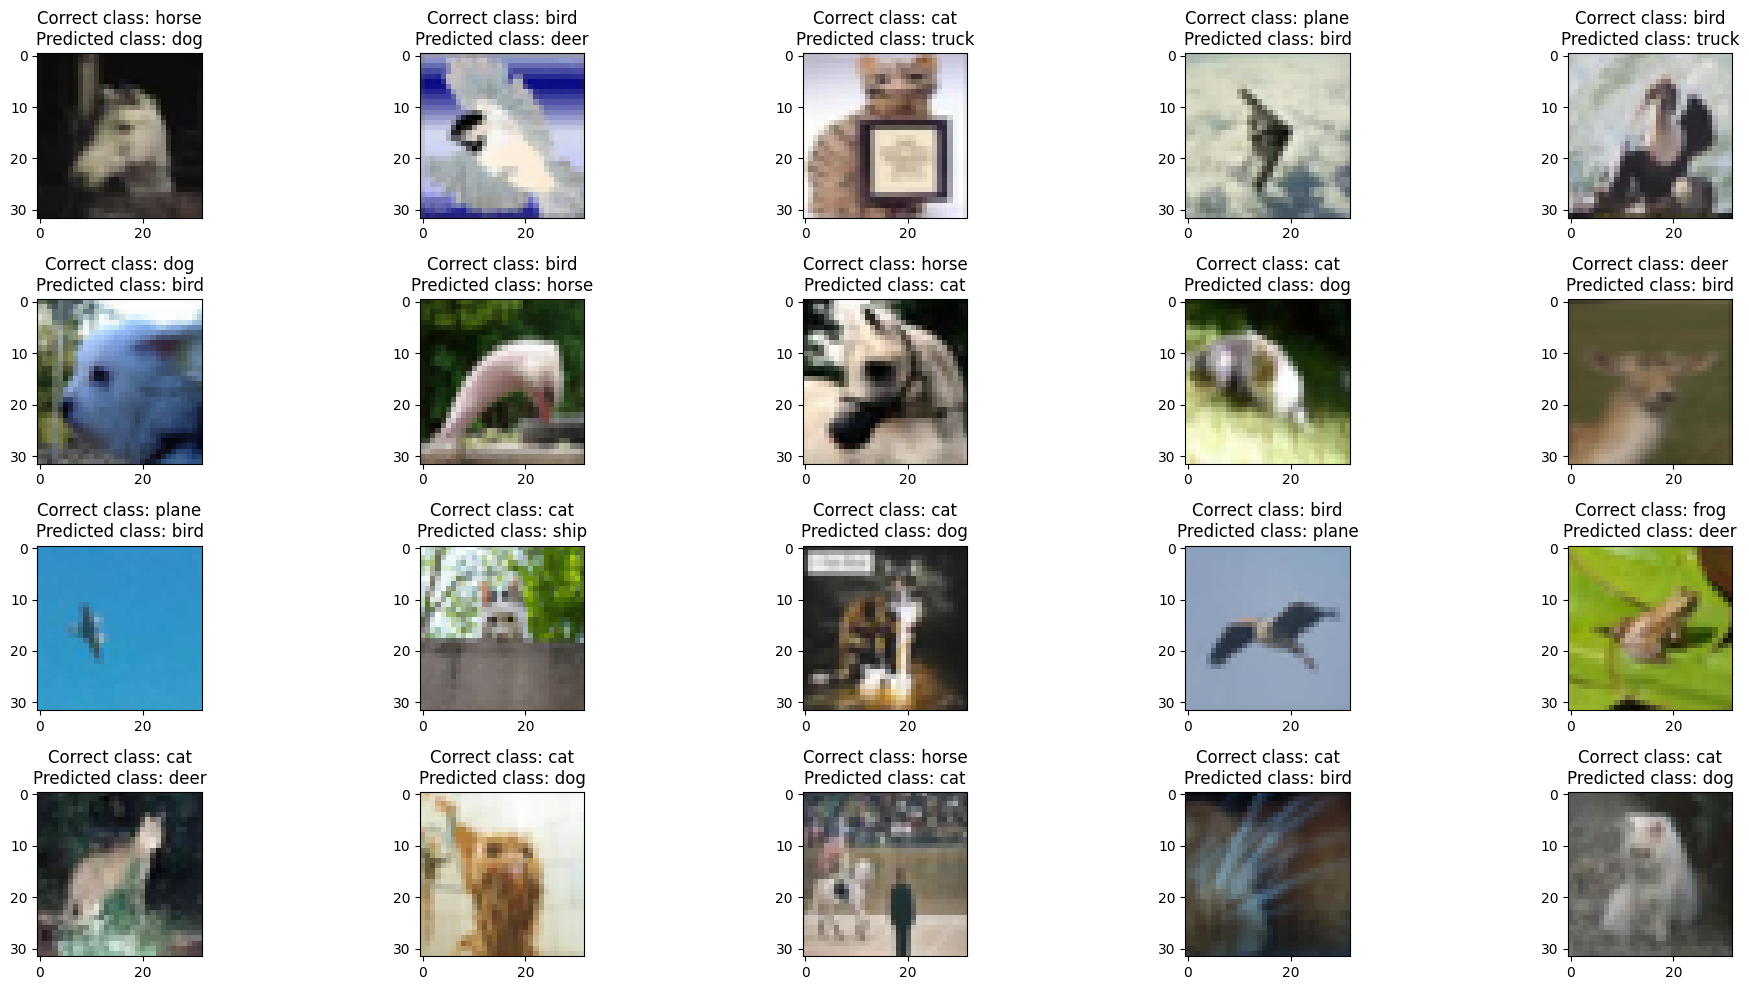

In [16]:
show_misclassified_images(model, test_loader, device)

# **Loss and Accuracy Graphs**


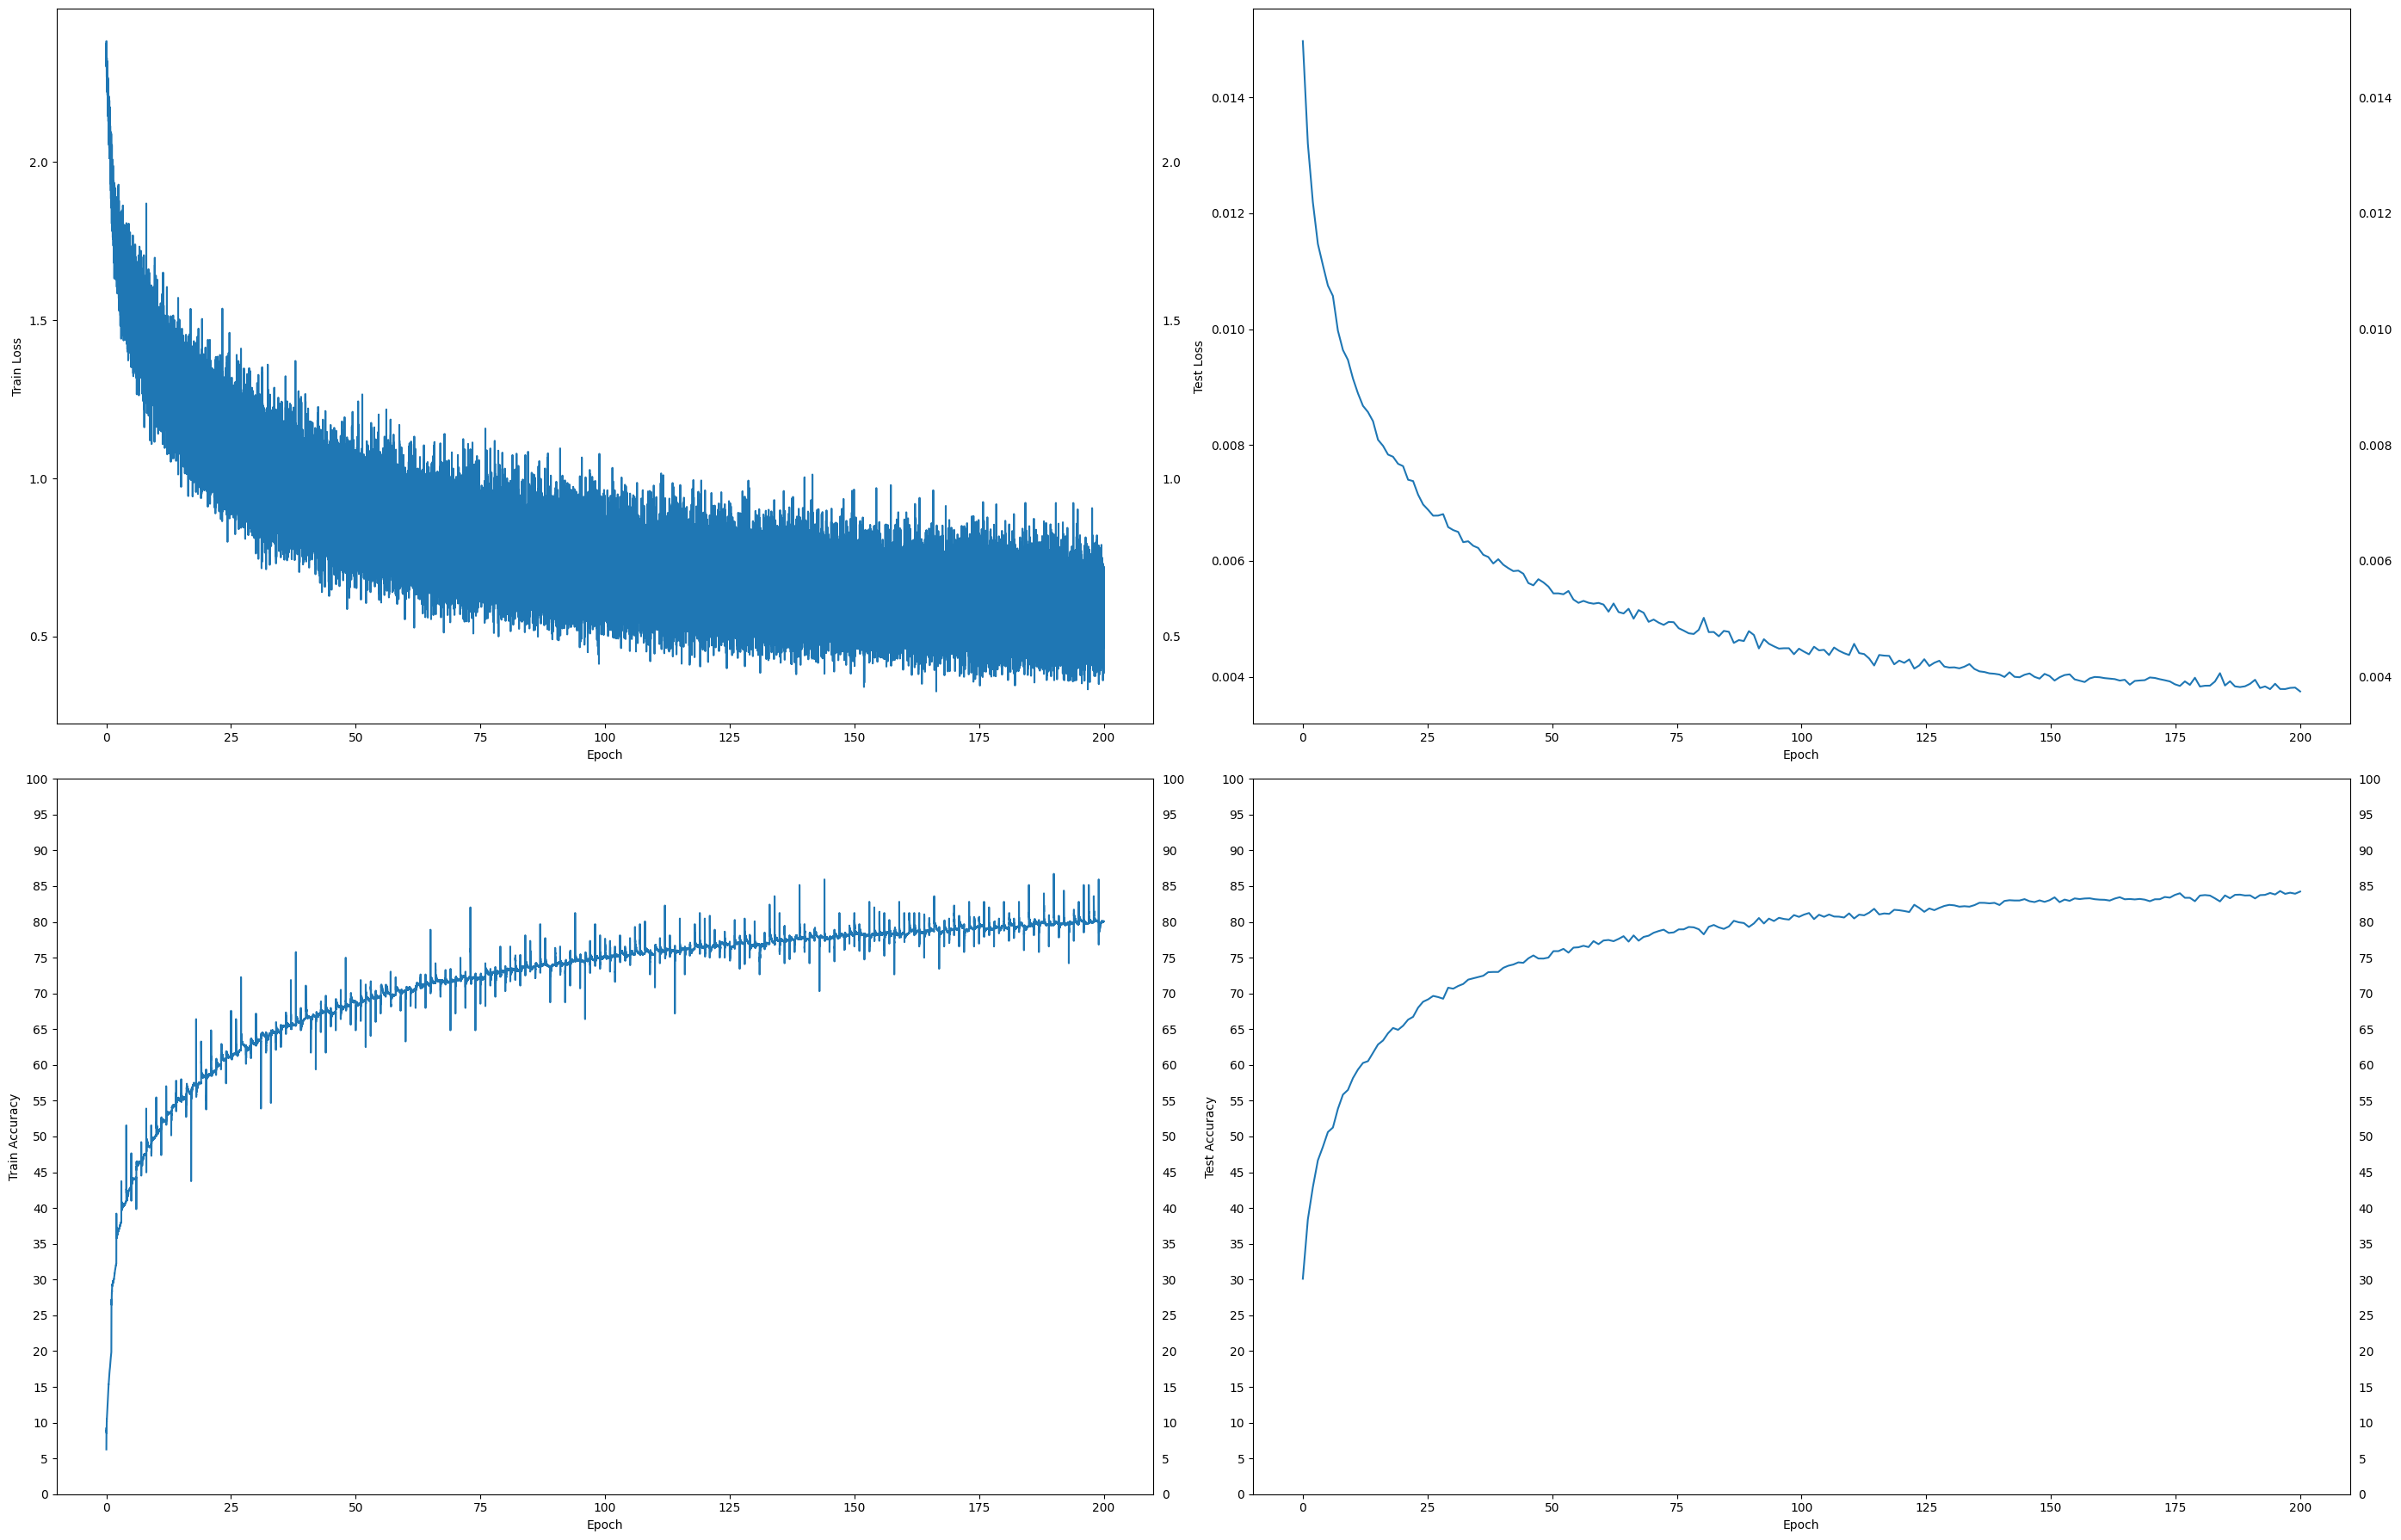

In [17]:
fig, ax = plt.subplots(2, 2)

train_epoch_loss_linspace = np.linspace(0, EPOCHS, len(trainer.train_losses))
test_epoch_loss_linspace = np.linspace(0, EPOCHS, len(tester.test_losses))
train_epoch_acc_linspace = np.linspace(0, EPOCHS, len(trainer.train_accuracies))
test_epoch_acc_linspace = np.linspace(0, EPOCHS, len(tester.test_accuracies))

ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Train Loss")
ax[0][0].plot(train_epoch_loss_linspace, trainer.train_losses)
ax[0][0].tick_params(axis="y", labelleft=True, labelright=True)

ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Test Loss")
ax[0][1].plot(test_epoch_loss_linspace, tester.test_losses)
ax[0][1].tick_params(axis="y", labelleft=True, labelright=True)

ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Train Accuracy")
ax[1][0].plot(train_epoch_acc_linspace, trainer.train_accuracies)
ax[1][0].tick_params(axis="y", labelleft=True, labelright=True)
ax[1][0].yaxis.set_ticks(np.arange(0, 101, 5))

ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Test Accuracy")
ax[1][1].plot(test_epoch_acc_linspace, tester.test_accuracies)
ax[1][1].tick_params(axis="y", labelleft=True, labelright=True)
ax[1][1].yaxis.set_ticks(np.arange(0, 101, 5))

fig.set_size_inches(28, 18)
plt.tight_layout()
plt.show()